# Integral RL
 - Continuous-time system
 - Model-free
 - Off-policy
 - Weighted residual method

In [1]:
import numpy as np
from scipy.signal import chirp, square
from scipy import linalg
import matplotlib.pyplot as plt

## System dynamics

Consider an LTI system with $\dot{x}\left(t\right)=Ax\left(t\right)+Bu(t)$ where

<center>$A=\left[ \begin{array}{cccc}
0 & 1 \\ 
2 & -4 \end{array} \right],\;
B=\left[ \begin{array}{cccc}
1 & 2 \\ 
0 & 1 \end{array} \right]$</center>

In [2]:
A = np.array([[0, 1], [2, -4]])
g = np.array([[1, 2], [0, 1]])

### Quadratic cost function 

In [3]:
r = np.diag([0.01, 0.01])
q = np.diag([50, 50])

### Solve CARE (continuous-time algebraic Riccati equation)

In [4]:
XX = linalg.solve_continuous_are(A, g, q, r)
# Note: L and G outputs from MATLAB's care aren't directly available in scipy
# but can be computed if needed: L = np.linalg.inv(r) @ g.T @ XX, G = g @ np.linalg.inv(r) @ g.T
u0 = np.random.rand(2, 1)

### Off-policy: Generate behavior policy

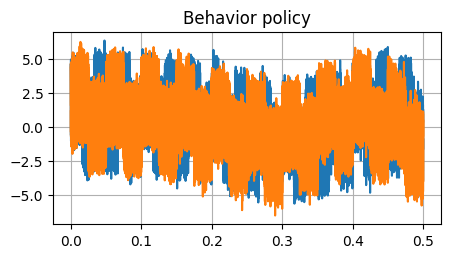

In [5]:
T = 0.5
dt = 0.000001
time = np.arange(0, T + dt, dt)

u = np.vstack([
    chirp(time, 0, T, 5) + square(2 * np.pi * 30 * time) + np.random.normal(0, 1, time.shape),
    chirp(time, 0, T, 6) + square(2 * np.pi * 20 * time) + np.random.normal(0, 1, time.shape)
])

plt.figure(figsize=(5, 2.5))
plt.plot(time,u[0,:])
plt.plot(time,u[1,:])
plt.title('Behavior policy')
plt.grid(True)
plt.show()


It can be shown that
<center>$\hat{W}^T_v\phi \left(t\right)=y$

where
<center>$y=\int^{t+T}_t{L^* d\tau }$

and
<center>$\mu_v \left(t\right)-\mu_v \left(t+T\right)+\int^{t+T}_t \frac{\partial \mu_v }{\partial x}B\left(u-u^*\right) d \tau$

> **TODO:** Derive these equations

In [6]:
len1 = len(time)
x = np.zeros((2, len1))
x[:, 0] = np.random.rand(2) * 100

U = np.zeros((2, len1))
t_I = 0.004
N = 10
len2 = round(t_I / dt)

Teta = np.zeros((3, len1))
Teta[:, 0] = 0.2 * np.array([1, 1, 1])

delta = 0
D_off = np.zeros((3, 1))
mu = np.array([[x[0, 0] ** 2], [x[0, 0] * x[1, 0]], [x[1, 0] ** 2]])

In [7]:
count = 0
count1 = 0
Y = np.zeros((N, 1))
PHI = np.zeros((N, 3))
xd = np.zeros((2, 1))

for i in range(len1 - 1):
    x1 = x[0, i]
    x2 = x[1, i]

    dmu_v = np.array([
        [2 * x1, 0],
        [x2, x1],
        [0, 2 * x2]
    ])

    f = A @ x[:, i].reshape(-1, 1)

    if (i + 1) % len2 == 0 and i > 0:
        count += 1
        mu0 = mu
        mu = np.array([[x1 ** 2], [x1 * x2], [x2 ** 2]])
        Beta = mu0 - mu + D_off
        PHI[count - 1, :] = Beta.flatten()
        Y[count - 1, 0] = delta
        delta = 0
        D_off = np.zeros((3, 1))
        u0 = (np.random.rand(2, 1) - 0.5) * 2

    if count == N:
        # Using np.linalg.lstsq for better numerical stability
        Teta[:, i] = np.linalg.lstsq(PHI, Y, rcond=None)[0].flatten()
    elif i > 0:
        Teta[:, i] = Teta[:, i - 1]

    U[:, i] = (-0.5 * np.linalg.solve(r, g.T) @ dmu_v.T @ Teta[:, i].reshape(-1, 1)).flatten()

    ddelta = float(x[:, i].reshape(1, -1) @ q @ x[:, i].reshape(-1, 1)) + float(U[:, i].reshape(1, -1) @ r @ U[:, i].reshape(-1, 1))
    delta += ddelta * dt

    D_off += (dmu_v @ g @ (u[:, i].reshape(-1, 1) - U[:, i].reshape(-1, 1))) * dt

    xd0 = xd
    xd = f + g @ u[:, i].reshape(-1, 1)
    a = (xd - xd0) / dt
    x[:, i + 1] = x[:, i].reshape(-1) + xd0.flatten() * dt + 0.5 * a.flatten() * dt ** 2

    if count == N:
        count = 0
        count1 += 1
        if count1 == 5:
            count1 = 0

> **TODO:** Solve for another system, like Quanser Helicopter

## Learning curves

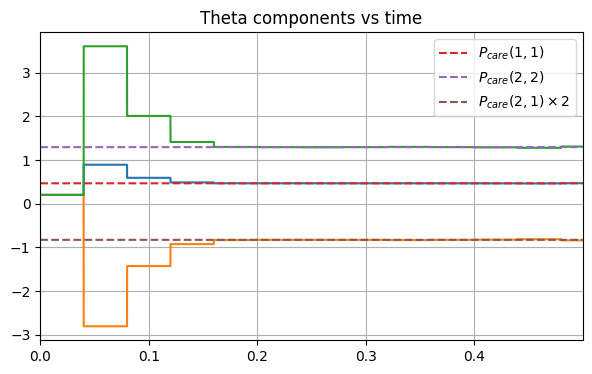

In [9]:
plt.figure(figsize=(7, 4))
plt.plot(time, Teta.T)
plt.plot(time, np.ones_like(time) * XX[0, 0], '--', label=r'$P_{care}(1,1)$')
plt.plot(time, np.ones_like(time) * XX[1, 1], '--', label=r'$P_{care}(2,2)$')
plt.plot(time, np.ones_like(time) * XX[1, 0] * 2, '--', label=r'$P_{care}(2,1) \times 2$')
plt.title('Theta components vs time')
plt.grid(True)
plt.legend()
plt.xlim(0,T-dt)
plt.show()